# Movielens 영화 SBR

* Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작
* ratings.dat에 있는 'UserId', 'ItemId', 'Time' 칼럼만 사용

## Model
## 중요 라이브러리 import

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### data load

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

In [3]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

### data 분석
* Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있다.
* Rating 은 일단 제외하도록 한다.
* userid는 영화 관람객 아이디이고 itemid는 영화 아이디이다.
* rating은 관람객이 영화에 별점을 준 수치이다.
* userid를 시간 순으로 정렬한다.

In [4]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [5]:
data = data.drop('Rating', axis=1)
data

,UserId,ItemId,Time
31,1,3186,978300019
22,1,1270,978300055
27,1,1721,978300055
37,1,1022,978300055
24,1,2340,978300103
...,...,...,...
1000019,6040,2917,997454429
999988,6040,1921,997454464
1000172,6040,1784,997454464
1000167,6040,161,997454486


### 데이터의 유니크한 갯수 확인하기

In [6]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

* UserId의 숫자가 6040개, 아이템 숫자는 3706개 이다.

* UserId가 세션의 역할을 한다.

## Session Length
* session_length란 해당 영화 관람객이 그 동안 몇번의 영화후기를 남겼는지의 의미가 된다.

In [7]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

* 중간값, 평균 출력

In [8]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [9]:
session_length.min(), session_length.max()

(20, 2314)

In [10]:
session_length.quantile(0.999)

1343.181000000005

### 데이터 시각화
* 2314라는 값은 너무 큰 값이므로 한번 확인해보기로 했다.

In [11]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Time
696969,4169,1268,965333392
697168,4169,2617,965333392
697185,4169,2628,965333392
697219,4169,2653,965333392
697275,4169,423,965333392
...,...,...,...
697882,4169,3754,1024174347
695702,4169,1413,1024175031
697358,4169,494,1024175760
695945,4169,1804,1024175783


In [12]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

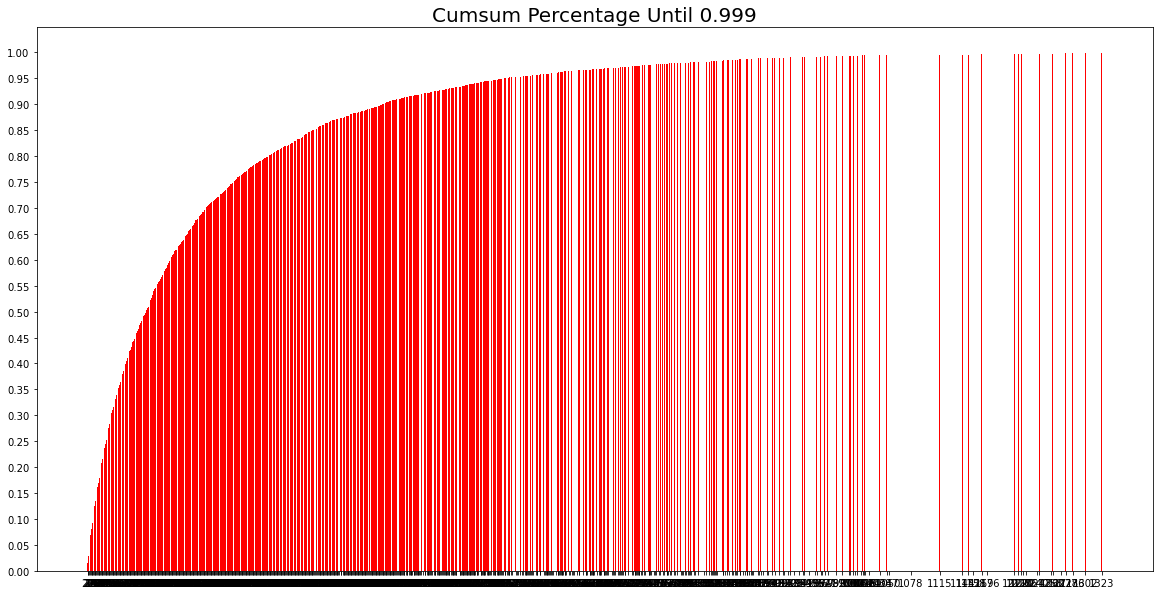

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

## Session Time
* 이 숫자가 대략 언제쯤을 나타내는지 확인하기로 했다.
* 초, 분 일, 년 단위로 나눠주었다.

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [15]:
# 분단위
data['Time'].min()//60, data['Time'].max()//60 

(15945065, 17440909)

In [16]:
# 년단위
data['Time'].min()//60//60//24//365, data['Time'].max()//60//60//24//365

(30, 33)

### 시간 데이터 분석
* 1970년 1월 1일부터 초단위로 측정한 시간 데이터 이다.
* 가장 오래된 데이터는 1970년부터 30년 뒤인 약2000년 데이터고, 가장 최근 데이터는 33년 뒤인 약2003년 데이터 이다.
* 먼저 데이터의 최근 1년 데이터만 사용해보기로 했다.
* 1년 = 12개월 = 365일 = 31,536,000 초

In [18]:
one_year = 31536000   
year_ago = latest - one_year    # 최종 날짜로부터 1년 이전 날짜를 구한다.  
data = data[data['Time'] > year_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Time
5170,36,1387,1015904819
5267,36,1201,1015904819
5122,36,1291,1015904836
5123,36,2167,1015904905
5290,36,2951,1015904905
...,...,...,...
992358,5996,3835,1020113184
992279,5996,2422,1020113225
992702,5996,168,1031058746
992459,5996,339,1033997079


## Data Cleansing
* userid의 min()을 확인했을 때 가장 길이가 작은 세션은 20 이였다. 이번 테스트는 20인 세션은 제거하고 21 이상 세션부터 사용하기로 한다.
* 위에서 userid 값만 확인했으므로 Itemid 값도 확인해본다.

In [19]:
ItemId_length = data.groupby('ItemId').size()
ItemId_length

ItemId
1       16
2       17
3        9
4        6
5        7
        ..
3948    49
3949    52
3950    13
3951     4
3952    22
Length: 2921, dtype: int64

In [20]:
ItemId_length.median(), ItemId_length.mean()

(5.0, 7.430332078055461)

In [21]:
ItemId_length.min(), ItemId_length.max()

(1, 62)

### Itemid 분석
* ItemId_length : 어떤 영화에 대해 사람들이 남긴 후기의 수
* 중간값이 5, 평균이 7.4이다.
* 보통 보고싶은 영화를 고를 때 영화 후기의 수는 중요하다.
* 평균이 5~7이지만, 일반적으로 후기의 수가 많을것을 보지 않을까? 라는 생각이 들기도 하지만 평론가나 영화 매니아들은 후기의 개수따위 중요하게 생각하지 않을 것 같다.

In [22]:
ItemId_length.quantile(0.999)

52.0

In [23]:
long_session = ItemId_length[ItemId_length==27].index[0]
data[data['ItemId']==long_session]

,UserId,ItemId,Time
18841,146,539,1022003797
63489,424,539,1016719839
95779,641,539,1019442321
141733,911,539,1038877357
178783,1121,539,1022867615
179880,1125,539,1036520164
193952,1194,539,1036310191
215747,1306,539,1026712304
229454,1389,539,1038286016
256154,1561,539,1024170998


In [24]:
length_count = ItemId_length.groupby(ItemId_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1     0.173571
2     0.297159
3     0.396440
4     0.477234
5     0.545361
6     0.604587
7     0.652174
8     0.696337
9     0.732283
10    0.762410
11    0.793906
12    0.818213
13    0.838754
14    0.852790
15    0.871619
16    0.888052
17    0.900377
18    0.908935
19    0.918179
20    0.928792
21    0.936666
22    0.944882
23    0.949675
24    0.957891
25    0.962342
26    0.965765
27    0.971927
28    0.976036
29    0.979801
30    0.983225
31    0.986306
32    0.986991
33    0.989045
34    0.989730
35    0.992126
36    0.992811
37    0.994180
38    0.995207
39    0.995549
40    0.995892
42    0.996577
43    0.996919
45    0.997261
48    0.997604
49    0.997946
51    0.998631
dtype: float64

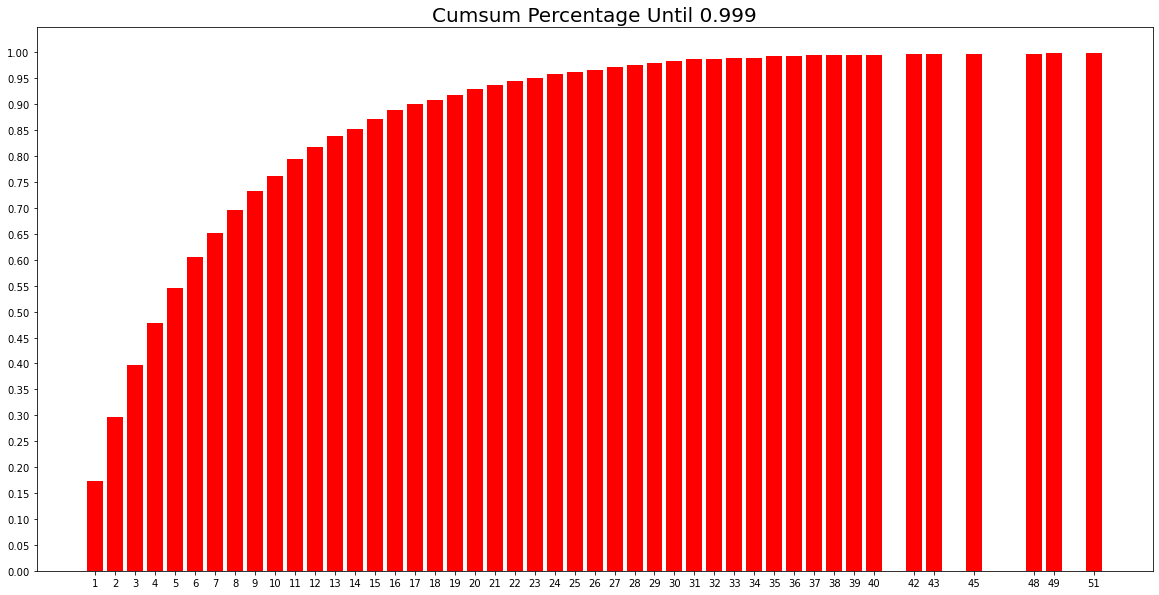

In [25]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [26]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

## shortest, least_click 값 정하기
* 1년치 데이터셋만 사용해서 데이터셋이 적기 때문에 데이터를 최대한 살리는 방향으로 했다.
* userid_length.min = 20, itemid_length.min = 1, 이였으므로, 이 값과 비슷하거나 같은 값을 넣었다.

In [27]:
data = cleanse_recursive(data, shortest=21, least_click=1)
data

,UserId,ItemId,Time
5170,36,1387,1015904819
5267,36,1201,1015904819
5122,36,1291,1015904836
5123,36,2167,1015904905
5290,36,2951,1015904905
...,...,...,...
992358,5996,3835,1020113184
992279,5996,2422,1020113225
992702,5996,168,1031058746
992459,5996,339,1033997079


## Train/ Valid/ Test split
* 1년 데이터중에 1개월 ~ 10개월 데이터는 train_dataset으로 활용한다.
* 나머지 1개월은 valid_dataset으로, 또 나머지 1개월은 train_dataset으로 활용한다.
* 입력일에 시, 분, 초를 곱해줘서 일 단위를 초 단위로 바꾸어 빼준뒤 split 해주었다.

In [28]:
def split_by_date(data: pd.DataFrame, n_days: int):
    n_seconds = n_days*24*60*60
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - n_seconds].index
    session_in_test = session_last_time[session_last_time >= final_time - n_seconds].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [29]:
tr, test = split_by_date(data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [30]:
tr.head()

,UserId,ItemId,Time
5170,36,1387,1015904819
5267,36,1201,1015904819
5122,36,1291,1015904836
5123,36,2167,1015904905
5290,36,2951,1015904905


In [31]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [32]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 9671
	 Sessions: 131
	 Items: 2387
	 First Time : 1014923199
	 Last Time : 1041195859

* valid Set Stats Info
	 Events: 2378
	 Sessions: 42
	 Items: 1243
	 First Time : 1015349521
	 Last Time : 1043799175

* test Set Stats Info
	 Events: 6962
	 Sessions: 77
	 Items: 2069
	 First Time : 1014955410
	 Last Time : 1046454590



### Sessions 확인
* train Set ,valid Set, test Set의 Sessions는 각각 131, 42, 77이다.

In [33]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [34]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## SessionDataset
* 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만든다.

In [35]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [36]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Time,item_idx
5170,36,1387,1015904819,0
5267,36,1201,1015904819,1
5122,36,1291,1015904836,2
5123,36,2167,1015904905,3
5290,36,2951,1015904905,4
5359,36,2115,1015904905,5
5073,36,1912,1015904924,6
5113,36,2662,1015904924,7
5366,36,2985,1015904941,8
5305,36,2527,1015904957,9


In [37]:
tr_dataset.click_offsets

array([   0,   34,   59,   80,  135,  208,  300,  344,  385,  408,  525,
        576,  732,  778,  821,  864,  925, 1054, 1216, 1789, 1811, 1844,
       1870, 1914, 1940, 1976, 2077, 2115, 2255, 2324, 2413, 2446, 2703,
       2733, 2807, 2991, 3117, 3206, 3230, 3264, 3311, 3425, 3448, 3478,
       3511, 3586, 3651, 3672, 3694, 3717, 3823, 3862, 3884, 3915, 3980,
       4011, 4067, 4232, 4297, 4387, 4418, 4452, 4706, 4793, 4862, 5005,
       5141, 5171, 5232, 5282, 5351, 5381, 5425, 5484, 5508, 5639, 5667,
       5699, 5795, 5853, 5915, 5963, 5987, 6209, 6237, 6366, 6398, 6429,
       6496, 6582, 6752, 6790, 6831, 6858, 6902, 7237, 7278, 7311, 7486,
       7554, 7583, 7609, 7703, 7738, 7938, 7999, 8025, 8055, 8076, 8331,
       8358, 8537, 8573, 8616, 8724, 8748, 8779, 8829, 8863, 8892, 8990,
       9014, 9035, 9074, 9164, 9253, 9334, 9363, 9469, 9527, 9548, 9671],
      dtype=int32)

In [38]:
tr_dataset.session_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130])

## SessionDataLoader
* SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만든다. __iter__ 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield한다. mask는 후에 RNN Cell State를 초기화 하는데 사용한다.

In [39]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=5):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [40]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Time,item_idx
5170,36,1387,1015904819,0
5267,36,1201,1015904819,1
5122,36,1291,1015904836,2
5123,36,2167,1015904905,3
5290,36,2951,1015904905,4
5359,36,2115,1015904905,5
5073,36,1912,1015904924,6
5113,36,2662,1015904924,7
5366,36,2985,1015904941,8
5305,36,2527,1015904957,9


In [41]:
iter_ex = iter(tr_data_loader)

In [42]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 34 16 78]
Label Item Idx are :       [ 1 35 58 79]
Previous Masked Input Idx are []


## Modeling
### Evaluation Metric
* 모델 성능 평가를 위한 지표.
* 모델 성능에 대한 지표로 precision이나 recall이 있다.
* Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋다.
* 이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용한다.
* 추천에서는 몇 번째로 맞추느냐도 중요하다. 
* 따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용한다.
* 이번 자료에서는 MRR과 Recall@k를 사용한다. 
* MRR은 정답 아이템이 나온 순번의 역수 값이다.
* 따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것이다.

### recall@k
* recall@k는 전체 relevant한 아이템 중 추천된 아이템이 속한 비율
### MRR@20
* Reciprocal rank는 첫 번째로 등장하는 relevant한 아이템이 우리의 추천상 몇 번째에 위치하는지를 나타내는 지표다. 하지만 그대로 몇 번째인지를 사용하면 앞에 나올 수록 좋은 모델이라는 것을 반대로 표현하게되니 역수를 취해주게 된다.

In [43]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture
* 모델 구조를 구현

### GRU란? 
* GRU(Gated Reccurent Unit)은 LSTM의 장기 의존성 문제를 해결하면서, 매번 은닉상태 업데이트 계산을 줄여 LSTM보다 Simple한 구조를 가진다.
* 출처 -:https://omicro03.medium.com/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-30%EC%9D%BC%EC%B0%A8-gru-4fce44eb4243

![Screenshot from 2021-03-18 02-38-50](https://user-images.githubusercontent.com/60597598/111512686-5ae79200-8793-11eb-9616-3976c8460bd9.png)

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [45]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

### Args 하이퍼 파라미터 조정
* 모델별 sessions 길이별로 args의 batch size를 조절해보자.
* train Set ,valid Set, test Set의 Sessions는 각각 131, 42, 77이므로 batchsize를 42보다 작은 값으로 해야한다.
* 그래서 32값을 넣어주었다.

In [46]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [47]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 1, 2387)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      365850    
_________________________________________________________________
dropout (Dropout)            (32, 50)                  0         
_________________________________________________________________
dense (Dense)                (32, 2387)                121737    
Total params: 487,587
Trainable params: 487,587
Non-trainable params: 0
_________________________________________________________________


In [48]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [49]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/298 [00:00<?, ?it/s, accuracy=0, train_loss=7.1]      

	 - Recall@20 epoch 1: 0.043981
	 - MRR@20    epoch 1: 0.009732



Train:   0%|          | 0/298 [00:00<?, ?it/s, accuracy=0, train_loss=7.01]     

	 - Recall@20 epoch 2: 0.047454
	 - MRR@20    epoch 2: 0.008910



Evaluation:  37%|███▋      | 27/73 [00:03<00:05,  8.43it/s]

	 - Recall@20 epoch 3: 0.046296
	 - MRR@20    epoch 3: 0.009321



In [50]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  58%|█████▊    | 124/215 [00:14<00:10,  8.40it/s]

	 - Recall@20: 0.028478
	 - MRR@20: 0.005467



## Model 결과 분석1
* 처음에 Args의 batch size를 2048로 해서 index 에러가 생겼다.
* 확인해보니 데이터셋별 세션 길이가 중요했고, valid데이터셋 세션 길이가 42여서 배치사이즈를 이보다 더 작은 값을 넣어주어야 했다.
* 그래서 batchsize =32를 넣고 학습을 시켰다.
* 오류는 해결되었지만 Recall@20, MRR@20수치가 매우 낮았다.
* 이는 데이터셋이 너무 적었다는 결론이 나왔다.
* 데이터셋을 1년치만 썼는데 전체 데이터셋을 쓰는 시도를 해볼 필요가 있다.

## 시도 1 : 전체 데이터셋으로 학습하기

In [49]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

In [50]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

In [51]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [52]:
data = data.drop('Rating', axis=1)
data

,UserId,ItemId,Time
31,1,3186,978300019
22,1,1270,978300055
27,1,1721,978300055
37,1,1022,978300055
24,1,2340,978300103
...,...,...,...
1000019,6040,2917,997454429
999988,6040,1921,997454464
1000172,6040,1784,997454464
1000167,6040,161,997454486


In [53]:
ItemId_length = data.groupby('ItemId').size()
ItemId_length

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3706, dtype: int64

In [54]:
data = cleanse_recursive(data, shortest=21, least_click=1)
data

,UserId,ItemId,Time
31,1,3186,978300019
22,1,1270,978300055
27,1,1721,978300055
37,1,1022,978300055
24,1,2340,978300103
...,...,...,...
1000019,6040,2917,997454429
999988,6040,1921,997454464
1000172,6040,1784,997454464
1000167,6040,161,997454486


In [55]:
tr, test = split_by_date(data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [56]:
tr.head()

,UserId,ItemId,Time
31,1,3186,978300019
22,1,1270,978300055
27,1,1721,978300055
37,1,1022,978300055
24,1,2340,978300103


In [57]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 918028
	 Sessions: 5772
	 Items: 3692
	 First Time : 956703932
	 Last Time : 1041215174

* valid Set Stats Info
	 Events: 29494
	 Sessions: 79
	 Items: 2977
	 First Time : 957547221
	 Last Time : 1043809240

* test Set Stats Info
	 Events: 50952
	 Sessions: 103
	 Items: 3198
	 First Time : 957179713
	 Last Time : 1046454590



In [58]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

In [59]:
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [60]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train1.pkl')
val.to_pickle(save_path / 'valid1.pkl')
test.to_pickle(save_path / 'test1.pkl')

In [61]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Time,item_idx
31,1,3186,978300019,0
22,1,1270,978300055,1
27,1,1721,978300055,2
37,1,1022,978300055,3
24,1,2340,978300103,4
36,1,1836,978300172,5
3,1,3408,978300275,6
7,1,2804,978300719,7
47,1,1207,978300719,8
0,1,1193,978300760,9


In [62]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 917564, 917687, 918028], dtype=int32)

In [63]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5769, 5770, 5771])

In [64]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Time,item_idx
31,1,3186,978300019,0
22,1,1270,978300055,1
27,1,1721,978300055,2
37,1,1022,978300055,3
24,1,2340,978300103,4
36,1,1836,978300172,5
3,1,3408,978300275,6
7,1,2804,978300719,7
47,1,1207,978300719,8
0,1,1193,978300760,9


In [65]:
iter_ex = iter(tr_data_loader)

In [66]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


In [67]:
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [68]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 1, 3692)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      561600    
_________________________________________________________________
dropout_1 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (32, 3692)                188292    
Total params: 749,892
Trainable params: 749,892
Non-trainable params: 0
_________________________________________________________________


In [79]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.65]

	 - Recall@20 epoch 1: 0.223016
	 - MRR@20    epoch 1: 0.058593



Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.79]

	 - Recall@20 epoch 2: 0.247028
	 - MRR@20    epoch 2: 0.069486



Evaluation:  71%|███████   | 652/919 [01:09<00:28,  9.33it/s]

	 - Recall@20 epoch 3: 0.258292
	 - MRR@20    epoch 3: 0.074301



In [80]:
test_model(model, args, test)

Evaluation:  78%|███████▊  | 1247/1589 [02:15<00:37,  9.22it/s]

	 - Recall@20: 0.247043
	 - MRR@20: 0.070059



## Model_1 결과분석2
- 약 3년치 dataset 중 1년치 dataset 사용 : Recall@20: 0.028478, MRR@20: 0.005467
 - all dataset 사용 : Recall@20: 0.247043, MRR@20: 0.070059
 
- epoch가 너무 작은것 같아 epoch만 늘려보기로 했다.

## 시도 2 : epoch 3 -> 15로 증감

In [69]:
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=20)

In [70]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(32, 1, 3692)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      561600    
_________________________________________________________________
dropout_2 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (32, 3692)                188292    
Total params: 749,892
Trainable params: 749,892
Non-trainable params: 0
_________________________________________________________________


In [71]:
train_model(model, args)

Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.99]

	 - Recall@20 epoch 1: 0.221099
	 - MRR@20    epoch 1: 0.058873



Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.75]

	 - Recall@20 epoch 2: 0.250623
	 - MRR@20    epoch 2: 0.070475



Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0, train_loss=5.6]      

	 - Recall@20 epoch 3: 0.259011
	 - MRR@20    epoch 3: 0.074443



Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0, train_loss=5.6]      

	 - Recall@20 epoch 4: 0.261887
	 - MRR@20    epoch 4: 0.076208



Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.48]

	 - Recall@20 epoch 5: 0.265481
	 - MRR@20    epoch 5: 0.076703



Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.43]

	 - Recall@20 epoch 6: 0.266919
	 - MRR@20    epoch 6: 0.078188



Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.66]

	 - Recall@20 epoch 7: 0.266344
	 - MRR@20    epoch 7: 0.078907



Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.49]

	 - Recall@20 epoch 8: 0.267446
	 - MRR@20    epoch 8: 0.079264



Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.47] 

	 - Recall@20 epoch 9: 0.264954
	 - MRR@20    epoch 9: 0.079355



Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0, train_loss=5.77]     

	 - Recall@20 epoch 10: 0.266871
	 - MRR@20    epoch 10: 0.079629



Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0, train_loss=5.36]     

	 - Recall@20 epoch 11: 0.264810
	 - MRR@20    epoch 11: 0.079239



Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0, train_loss=5.56]     

	 - Recall@20 epoch 12: 0.264571
	 - MRR@20    epoch 12: 0.078585



Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.52]

	 - Recall@20 epoch 13: 0.263564
	 - MRR@20    epoch 13: 0.078375



Train:   0%|          | 0/28508 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.54]

	 - Recall@20 epoch 14: 0.263756
	 - MRR@20    epoch 14: 0.078473



Evaluation:  71%|███████   | 652/919 [01:07<00:27,  9.66it/s]

	 - Recall@20 epoch 15: 0.262605
	 - MRR@20    epoch 15: 0.077697



In [73]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [74]:
test_model(model, args, test)

Evaluation:  78%|███████▊  | 1247/1589 [02:08<00:35,  9.67it/s]

	 - Recall@20: 0.249298
	 - MRR@20: 0.072946



## Model_2 결과분석3
 - 약 3년치 dataset 중 1년치 dataset 사용 : Recall@20: 0.028478, MRR@20: 0.005467
 - all dataset 사용 : Recall@20: 0.247043, MRR@20: 0.070059
 - all dataset, epoch 15 : Recall@20: 0.249298 MRR@20: 0.072946
* 배치사이즈 32일 때 epoch15까지 돌리던 중 epoch11부터 recall,MRR값 하락이 일어났다. epoch은 10정도로 주는것이 좋을것 같다.

* 이전에 data = cleanse_recursive(data, shortest=21, least_click=1) 이 값을 넣어줬었는데 shortest는 한 사람이 영화후기를 남긴 수, least_click은 어떤 영화에 대해 사람들이 남긴 후기의 수 이다. 생각을 해보니 이 값을 수정할 필요가 있는 것 같다. 누가 후기가 1개밖에 없는 영화를 보고싶어 할까? 그리고 후기를 좀 더 많이 쓴 사람의 데이터가 좋지 않을까? 라는 생각이 들었다.
* 그래서 shortest는 30, least_click은 20으로 수정하기로 했다.

* 그리고 validation과 test dataset이 30일은 너무 적은것 같아 60일로 더 늘려주었다.

## 시도 3 
* validation과 test dataset 30일 -> 60일 증감
* shortest는 30, least_click은 20으로 수정
* epoch 10

In [75]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.

In [76]:
data = data.drop('Rating', axis=1)

In [77]:
data = cleanse_recursive(data, shortest=30, least_click=20)
data

,UserId,ItemId,Time
31,1,3186,978300019
22,1,1270,978300055
27,1,1721,978300055
37,1,1022,978300055
24,1,2340,978300103
...,...,...,...
1000019,6040,2917,997454429
999988,6040,1921,997454464
1000172,6040,1784,997454464
1000167,6040,161,997454486


In [78]:
# 30에서 60으로 변경
tr, test = split_by_date(data, n_days=60)
tr, val = split_by_date(tr, n_days=60)

In [79]:
tr.head()

,UserId,ItemId,Time
31,1,3186,978300019
22,1,1270,978300055
27,1,1721,978300055
37,1,1022,978300055
24,1,2340,978300103


In [80]:
test.tail()

,UserId,ItemId,Time
984731,5950,3948,1046369637
984682,5950,3578,1046369670
984475,5950,3793,1046369710
984660,5950,3555,1046369737
984733,5950,1262,1046369858


* test ssesion :5008, valid session=95, test session=181

In [81]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 863612
	 Sessions: 5008
	 Items: 3032
	 First Time : 956703932
	 Last Time : 1035933891

* valid Set Stats Info
	 Events: 33589
	 Sessions: 95
	 Items: 2751
	 First Time : 956853488
	 Last Time : 1041215174

* test Set Stats Info
	 Events: 79888
	 Sessions: 181
	 Items: 3007
	 First Time : 957179713
	 Last Time : 1046454590



In [82]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

In [83]:
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [84]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train2.pkl')
val.to_pickle(save_path / 'valid2.pkl')
test.to_pickle(save_path / 'test2.pkl')

In [85]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Time,item_idx
31,1,3186,978300019,0
22,1,1270,978300055,1
27,1,1721,978300055,2
37,1,1022,978300055,3
24,1,2340,978300103,4
36,1,1836,978300172,5
3,1,3408,978300275,6
7,1,2804,978300719,7
47,1,1207,978300719,8
0,1,1193,978300760,9


In [86]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Time,item_idx
31,1,3186,978300019,0
22,1,1270,978300055,1
27,1,1721,978300055,2
37,1,1022,978300055,3
24,1,2340,978300103,4
36,1,1836,978300172,5
3,1,3408,978300275,6
7,1,2804,978300719,7
47,1,1207,978300719,8
0,1,1193,978300760,9


In [87]:
iter_ex = iter(tr_data_loader)

In [88]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 56]
Label Item Idx are :       [  1  54  62 208]
Previous Masked Input Idx are []


* epoch 15->10 변경

In [89]:
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [90]:
model = create_model(args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(32, 1, 3032)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      462600    
_________________________________________________________________
dropout_3 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (32, 3032)                154632    
Total params: 617,232
Trainable params: 617,232
Non-trainable params: 0
_________________________________________________________________


In [91]:
train_model(model, args)

Train:   0%|          | 0/26831 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.37]

	 - Recall@20 epoch 1: 0.243032
	 - MRR@20    epoch 1: 0.064144



Train:   0%|          | 0/26831 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.52]

	 - Recall@20 epoch 2: 0.273698
	 - MRR@20    epoch 2: 0.076457



Train:   0%|          | 0/26831 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.02]

	 - Recall@20 epoch 3: 0.280374
	 - MRR@20    epoch 3: 0.080445



Train:   0%|          | 0/26831 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.62]

	 - Recall@20 epoch 4: 0.285422
	 - MRR@20    epoch 4: 0.082467



Train:   0%|          | 0/26831 [00:00<?, ?it/s, accuracy=0, train_loss=5.63]     

	 - Recall@20 epoch 5: 0.287300
	 - MRR@20    epoch 5: 0.083078



Train:   0%|          | 0/26831 [00:00<?, ?it/s, accuracy=0, train_loss=5.66]     

	 - Recall@20 epoch 6: 0.288593
	 - MRR@20    epoch 6: 0.083967



Train:   0%|          | 0/26831 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.44]

	 - Recall@20 epoch 7: 0.288802
	 - MRR@20    epoch 7: 0.084039



Train:   0%|          | 0/26831 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.4] 

	 - Recall@20 epoch 8: 0.287216
	 - MRR@20    epoch 8: 0.084496



Train:   0%|          | 0/26831 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.6] 

	 - Recall@20 epoch 9: 0.286257
	 - MRR@20    epoch 9: 0.084817



Evaluation:  72%|███████▏  | 749/1046 [01:15<00:29,  9.92it/s]

	 - Recall@20 epoch 10: 0.286048
	 - MRR@20    epoch 10: 0.085028



In [92]:
test_model(model, args, test)

Evaluation:  87%|████████▋ | 2176/2490 [03:48<00:32,  9.54it/s]

	 - Recall@20: 0.251551
	 - MRR@20: 0.074274



## Model_3 결과분석4
* 성능이 약간 향상되었지만 생각보다 미묘한 변화였다.
* 이번엔 shortest와 least_click에 UserID와 ItemID length의 median 값으로 넣기로 했다.

## 시도 4
* * shortest는 96, least_click은 7로 수정

In [93]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.

In [94]:
data = data.drop('Rating', axis=1)

In [95]:
data = cleanse_recursive(data, shortest=96, least_click=7)

In [96]:
tr, test = split_by_date(data, n_days=60)
tr, val = split_by_date(tr, n_days=60)

In [97]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 741348
	 Sessions: 2769
	 Items: 3322
	 First Time : 956703932
	 Last Time : 1035933891

* valid Set Stats Info
	 Events: 32975
	 Sessions: 84
	 Items: 2841
	 First Time : 956853488
	 Last Time : 1041215174

* test Set Stats Info
	 Events: 79428
	 Sessions: 168
	 Items: 3216
	 First Time : 957179713
	 Last Time : 1046454590



In [98]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

In [99]:
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [100]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train1.pkl')
val.to_pickle(save_path / 'valid1.pkl')
test.to_pickle(save_path / 'test1.pkl')

In [101]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Time,item_idx
130,2,1198,978298124,0
64,2,1210,978298151,1
71,2,1217,978298151,2
134,2,2717,978298196,3
88,2,1293,978298261,4
170,2,2943,978298372,5
106,2,1225,978298391,6
120,2,1193,978298413,7
172,2,318,978298413,8
70,2,3030,978298434,9


In [102]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)

In [103]:
iter_ex = iter(tr_data_loader)

In [104]:
inputs, labels, mask =  next(iter_ex)

In [105]:
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [106]:
model = create_model(args)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(32, 1, 3322)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      506100    
_________________________________________________________________
dropout_4 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_4 (Dense)              (32, 3322)                169422    
Total params: 675,522
Trainable params: 675,522
Non-trainable params: 0
_________________________________________________________________


In [107]:
train_model(model, args)

Train:   0%|          | 0/23080 [00:00<?, ?it/s, accuracy=0, train_loss=5.34]     

	 - Recall@20 epoch 1: 0.228814
	 - MRR@20    epoch 1: 0.059497



Train:   0%|          | 0/23080 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.21]

	 - Recall@20 epoch 2: 0.270890
	 - MRR@20    epoch 2: 0.075316



Evaluation:  72%|███████▏  | 739/1027 [01:14<00:29,  9.87it/s]

	 - Recall@20 epoch 3: 0.280827
	 - MRR@20    epoch 3: 0.080443



In [108]:
test_model(model, args, test)

Evaluation:  88%|████████▊ | 2172/2476 [03:42<00:31,  9.77it/s]

	 - Recall@20: 0.245051
	 - MRR@20: 0.070032



## Model_4 결과분석5
* 별 차이가 없었다. 성능이 약간 하락했다.
* 중요한 사실을 깨달았다. stats_info를 확인했을 때 시간이 순서대로 정렬되있어야 하는데 뒤죽박죽이였다.
* First Time : 956703932, Last Time : 1035933891 이 값이 비정상적이였다.
* 아무래도 시계열을 초 단위로 계산하는 과정이 문제가 있는 것 같아 연원일 단위로 바꾸는 방법을 적용했다.

# 시도 5
* 시계열값 변경
* least_click =100 으로 수정

In [144]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.

In [145]:
data = data.drop('Rating', axis=1)

In [146]:
# 시간 변환
import datetime, time 
times = data["Time"] 
tmp_list = [] 
for time in times: 
    tmp_date = dt.datetime.fromtimestamp(time)
    tmp_list.append(tmp_date)
data["Time"] = tmp_list 
data

,UserId,ItemId,Time
31,1,3186,2001-01-01 07:00:19
22,1,1270,2001-01-01 07:00:55
27,1,1721,2001-01-01 07:00:55
37,1,1022,2001-01-01 07:00:55
24,1,2340,2001-01-01 07:01:43
...,...,...,...
1000019,6040,2917,2001-08-10 23:40:29
999988,6040,1921,2001-08-10 23:41:04
1000172,6040,1784,2001-08-10 23:41:04
1000167,6040,161,2001-08-10 23:41:26


In [125]:
data['Time'].min(), data['Time'].max()

(Timestamp('2000-04-26 08:05:32'), Timestamp('2003-03-01 02:49:50'))

* 2000-04-26 08:05:32부터 2003-03-01 02:49:50까지의 데이터이다.

In [147]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [148]:
data = cleanse_recursive(data, shortest=96, least_click=100)

In [149]:
data.sort_values(['Time'], inplace=True)
data

,UserId,ItemId,Time
1000138,6040,858,2000-04-26 08:05:32
999873,6040,593,2000-04-26 08:05:54
1000153,6040,2384,2000-04-26 08:05:54
1000007,6040,1961,2000-04-26 08:06:17
1000192,6040,2019,2000-04-26 08:06:17
...,...,...,...
825526,4958,3489,2003-03-01 02:45:20
825793,4958,2399,2003-03-01 02:45:38
825438,4958,1407,2003-03-01 02:47:23
825724,4958,3264,2003-03-01 02:49:08


In [150]:
tr, test = split_by_date(data, n_days=60)
tr, val = split_by_date(tr, n_days=60)

In [151]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 683506
	 Sessions: 2678
	 Items: 1921
	 First Time : 2000-04-26 08:05:32
	 Last Time : 2002-10-30 08:24:51

* valid Set Stats Info
	 Events: 31793
	 Sessions: 86
	 Items: 1915
	 First Time : 2000-04-28 01:38:08
	 Last Time : 2002-12-30 11:26:14

* test Set Stats Info
	 Events: 69134
	 Sessions: 157
	 Items: 1921
	 First Time : 2000-05-01 20:15:13
	 Last Time : 2003-03-01 02:49:50



In [152]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

In [153]:
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [154]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train1.pkl')
val.to_pickle(save_path / 'valid1.pkl')
test.to_pickle(save_path / 'test1.pkl')

In [155]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Time,item_idx
1000138,6040,858,2000-04-26 08:05:32,0
999873,6040,593,2000-04-26 08:05:54,1
1000153,6040,2384,2000-04-26 08:05:54,2
1000007,6040,1961,2000-04-26 08:06:17,3
1000192,6040,2019,2000-04-26 08:06:17,4
999877,6040,1419,2000-04-26 08:07:36,5
999967,6040,3111,2000-04-26 08:07:36,6
999980,6040,3505,2000-04-26 08:07:36,7
1000155,6040,1734,2000-04-26 08:08:01,8
999884,6040,912,2000-04-26 08:09:51,9


In [156]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)

In [157]:
iter_ex = iter(tr_data_loader)

In [158]:
inputs, labels, mask =  next(iter_ex)

In [159]:
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [160]:
model = create_model(args)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(32, 1, 1921)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      295950    
_________________________________________________________________
dropout_5 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_5 (Dense)              (32, 1921)                97971     
Total params: 393,921
Trainable params: 393,921
Non-trainable params: 0
_________________________________________________________________


In [161]:
train_model(model, args)

Train:   0%|          | 0/21275 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.16]

	 - Recall@20 epoch 1: 0.234844
	 - MRR@20    epoch 1: 0.054790



Train:   0%|          | 0/21275 [00:00<?, ?it/s, accuracy=0, train_loss=6.04]     

	 - Recall@20 epoch 2: 0.268911
	 - MRR@20    epoch 2: 0.063806



Train:   0%|          | 0/21275 [00:00<?, ?it/s, accuracy=0, train_loss=5.94]     

	 - Recall@20 epoch 3: 0.276735
	 - MRR@20    epoch 3: 0.066591



Train:   0%|          | 0/21275 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.88]

	 - Recall@20 epoch 4: 0.280088
	 - MRR@20    epoch 4: 0.068015



Train:   0%|          | 0/21275 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.85]

	 - Recall@20 epoch 5: 0.279864
	 - MRR@20    epoch 5: 0.069690



Train:   0%|          | 0/21275 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.05]

	 - Recall@20 epoch 6: 0.282010
	 - MRR@20    epoch 6: 0.070421



Train:   0%|          | 0/21275 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.66]

	 - Recall@20 epoch 7: 0.280803
	 - MRR@20    epoch 7: 0.070597



Train:   0%|          | 0/21275 [00:00<?, ?it/s, accuracy=0, train_loss=5.76]     

	 - Recall@20 epoch 8: 0.280579
	 - MRR@20    epoch 8: 0.070796



Train:   0%|          | 0/21275 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.95]

	 - Recall@20 epoch 9: 0.279864
	 - MRR@20    epoch 9: 0.070269



Evaluation:  71%|███████   | 699/990 [01:09<00:29, 10.01it/s]

	 - Recall@20 epoch 10: 0.278121
	 - MRR@20    epoch 10: 0.070027



In [162]:
test_model(model, args, test)

Evaluation:  87%|████████▋ | 1868/2155 [03:12<00:29,  9.71it/s]

	 - Recall@20: 0.241569
	 - MRR@20: 0.060024



# 정리
![pic](https://user-images.githubusercontent.com/60597598/111527588-6fcc2180-87a3-11eb-951a-cc29074f7510.png)

## 마치며..
* Session에 맞춰 batchsize 조정을 해서 에러 해결을 하였다.
* 다양한 하이퍼파라미터 조절을 한 결과 데이터셋 크기 조절을 했을 때 Recall@k값과 MRR과  가장 크게 향상되었다.
* epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것을 확인했다. loss가 6점 대에서 5점대로 내려가는 것을 볼 수 있었다. Recall@k값도 0.23정도에서 0.27점대로 증가했다. MRR도 0.054에서 0.07로 증가했다.
* 가장 좋은 모델은 shortest=30, least_click=20 이고 n_days=60, epoch = 10 일때 Recall@k = 0.251551, MRR = 0.074274 이다.